_Выполнил Смердов Антон, ник Ciroel_
# Описание решения соревнования BlackBox Challenge
Организаторы представили соревнование как задачу обучения с подкреплением, поэтому участники пытались реализовать Q-learning и прочие подобные алгоритмы, однако мало у кого это получилось. Кроме того, был представлен базовый агент в виде линейной регрессии, и, как нетрудно было ожидать, многие "умельцы" стали подкручивать её коэффициенты. 

Мы пойдём другим путём. Давайте очень пристально посмотрим на данные и попытаемся понять структуру "чёрного ящика".

_Весь представленный код можно выполнить за 5-10 минут._

In [1]:
import interface as bbox
# cimport interface as bbox
import time; import math
import numpy as np
from sklearn.externals import joblib
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import *
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from seaborn import *
%matplotlib inline

In [2]:
n_actions = 4; n_features = 36
bbox.load_level("levels/train_level.data", verbose=1)
n_rows = bbox.get_max_time()

Level has been loaded: max_time = 1214494, n_features = 36, n_actions = 4


Для каждого из четырёх доступных действий пройдём чёрный ящик, используя только это действие. При этом будем сохранять в переменные $total\_score, states$ и $f\_35$ значение текущего счёта, состояние среды(с 0 по 34 переменную включительно) и состояние 35-ой переменной соответственно.

In [3]:
total_score, f_35 = np.zeros((n_actions,n_rows)), np.zeros((n_actions,n_rows))
states = np.zeros((n_actions,n_rows,n_features-1))
n_step = 0; has_next = True

for act in range(n_actions):
    while has_next:
        state = bbox.get_state()
        states[act,n_step,:] = state[:35].copy()
        has_next = bbox.do_action(act)
        total_score[act,n_step] = bbox.get_score()
        f_35[act,n_step] = state[35].copy()
        n_step+=1
    score = bbox.finish(verbose=0)
    print('act = '+str(act)+'  score = %.0f'%score)
    bbox.reset_level(); has_next = True; n_step = 0

act = 0  score = -12637
act = 1  score = -17979
act = 2  score = -14772
act = 3  score = -9832


# Смотрим на данные

Можно убедиться, что состояния переменных 0-34 не зависят от действий агента:

In [4]:
print(abs(states[0]-states[1]).max(),abs(states[0]-states[2]).max(),abs(states[0]-states[3]).max())

0.0 0.0 0.0


Что нельзя сказать про переменную 35:

In [5]:
print(abs(f_35[0]-f_35[1]).max(),abs(f_35[0]-f_35[2]).max(),abs(f_35[0]-f_35[3]).max())

2.20000004768 2.20000004768 1.10000002384


Начнём с не зависящих от действий переменных.
Взглянем на их распределения.  
_Можно увеличить картинку двойным кликом_

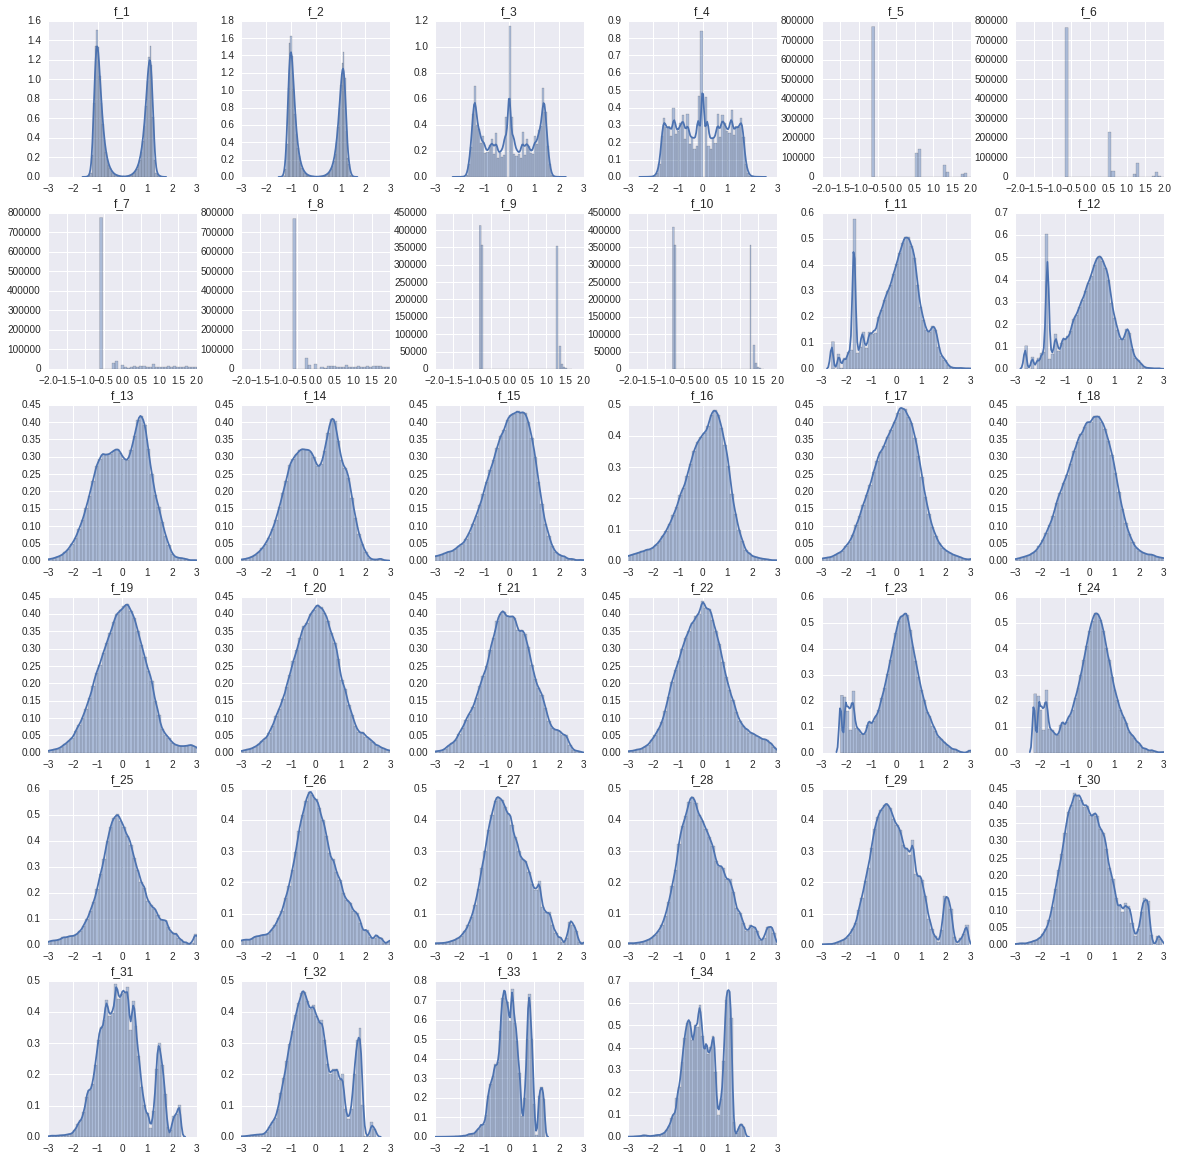

In [6]:
figsize = (20, 20)
rows = 6; cols = 6
gs = gridspec.GridSpec(rows,cols,wspace=0.3,hspace=0.23)
fig = plt.figure(figsize=figsize)
ax = []
for i in range(1,35):
    ax.append(fig.add_subplot(gs[(i-1)//cols,(i-1)%cols]))
    ax[-1].set_title('f_'+str(i))
    if (i >=5) & (i <=10): plot_kde = False; xlim = 2
    else: plot_kde = True; xlim = 3
    ax[-1] = distplot(states[0][:,i][abs(states[0][:,i]) < 3.5],kde=plot_kde)
    plt.xlim(-xlim,xlim)

In [7]:
np.std(states[0],axis=0)

array([ 0.99999976,  1.00000011,  0.99999991,  0.99999959,  0.99999964,
        0.99999979,  0.99999982,  0.99999971,  0.99999973,  0.99999983,
        0.99999985,  1.00000137,  0.99999962,  1.00000166,  1.00000072,
        0.99999976,  1.00000312,  0.99999968,  1.00000065,  0.99999964,
        0.99999962,  0.9999997 ,  0.99999972,  0.99999958,  0.99999957,
        0.9999999 ,  0.99999956,  0.99999958,  0.99999958,  0.99999958,
        0.99999987,  0.99999959,  0.9999996 ,  0.99999958,  0.99999959])

Легко видеть, что переменные отнормированы и идут парами со схожими распределениями, большинство из них непрерывны. Нулевая переменная является дискретной и у неё нет пары:

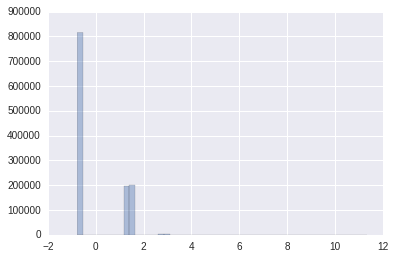

In [8]:
distplot(states[0][:,0],kde=False)

Построим корелляционную матрицу:

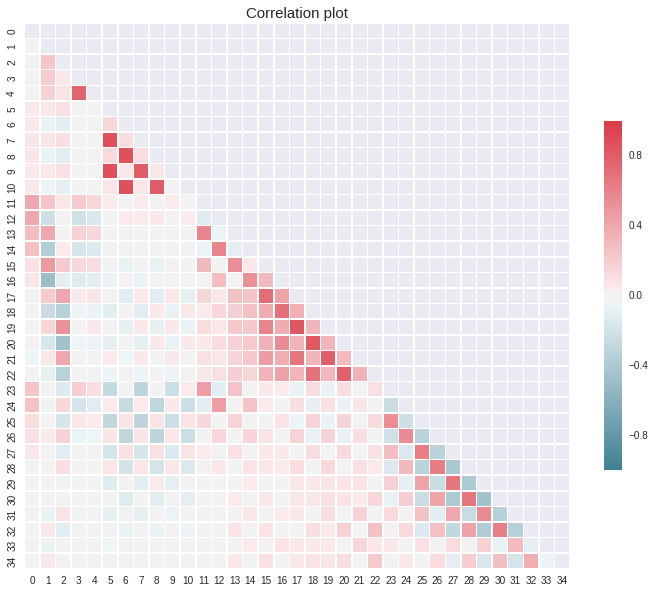

In [9]:
df_states = pd.DataFrame(states[0])
corr_data = df_states.corr()
mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
cmap = diverging_palette(220, 10, as_cmap=True)
heatmap(corr_data, mask=mask, cmap=cmap, vmax=1,vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation plot', fontsize=15)
plt.tight_layout()

Переменные идут группами со схожей природой: особенно это проявляется для состояний 5-10(дискретные переменные), 11-14, 15-22 и 23-32.

Теперь посмотрим на последнюю переменную, зависящую от действий агента.

### Действие 0

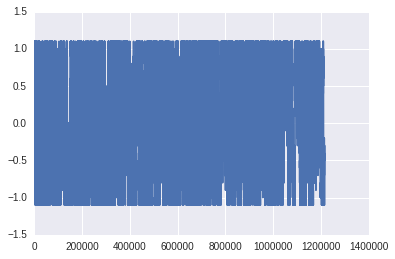

In [10]:
plt.plot(f_35[0])

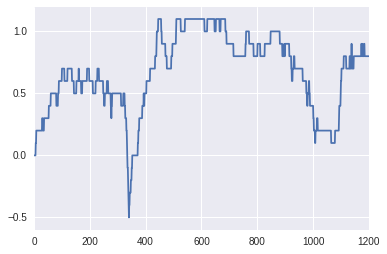

In [11]:
plt.plot(f_35[0][:1200])

Итоговый счёт:

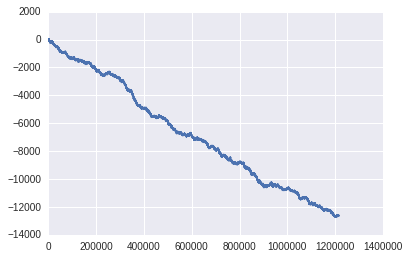

In [12]:
plt.plot(total_score[0])

Как можно видеть, действие 0 может изменять значение $f\_35$ как в большую, так и в меньшую сторону. Из графика следует, что модуль $f\_35$ ограничен числом 1.1.

### Действие 1

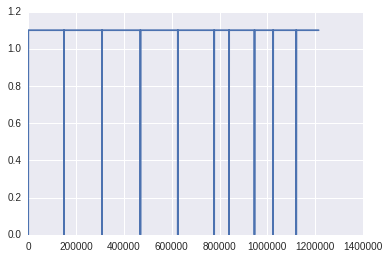

In [13]:
plt.plot(f_35[1])

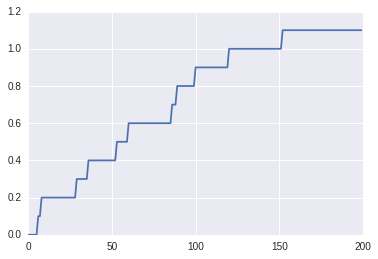

In [14]:
plt.plot(f_35[1][:200])

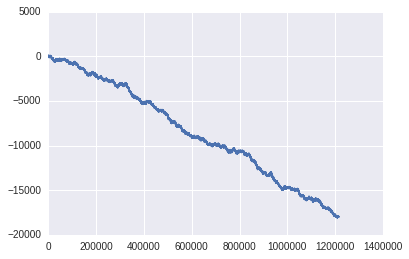

In [15]:
plt.plot(total_score[1])

Легко заметить, что действие 1 не уменьшает $f\_35$ и через несколько сотен шагов приводит значение переменной к максимальному значению 1.1. 

### Действие 2

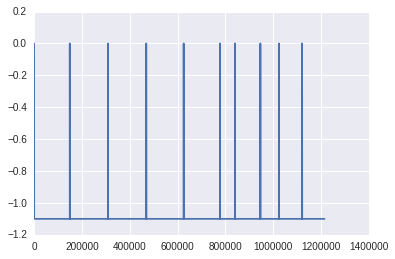

In [16]:
plt.plot(f_35[2])

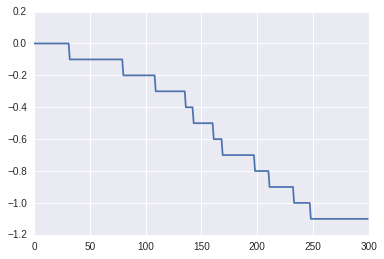

In [17]:
plt.plot(f_35[2][:300])

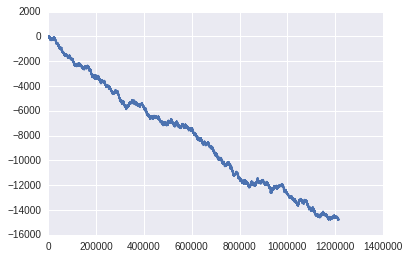

In [18]:
plt.plot(total_score[2])

Действие 2 не увеличивает значение $f\_35$ и постепенно доводит его до -1.1. Похоже, что это "антагонист" первого действия.  
Стоит обратить внимание на периодически возникающие обнуления $f\_35$, которые встречались также при рассмотрении действия 1, причём в те же самые моменты времени. По-видимому, эти обнуления не зависят от наших действий. Назовём их новыми эпохами и запомним их координаты:

In [19]:
new_epoches = np.array([0,149257,308751,469050,625520,777567,839881,946102,1024054,1120743])

### Действие 3

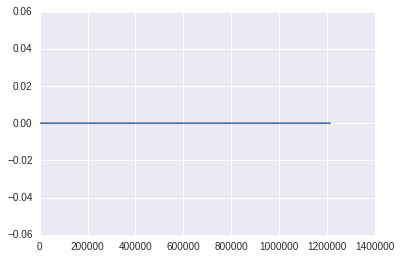

In [20]:
plt.plot(f_35[3])

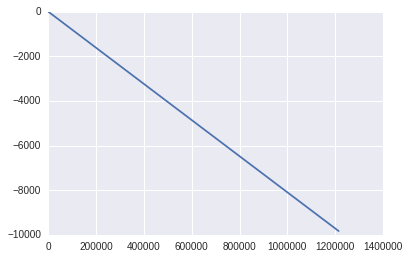

In [21]:
plt.plot(total_score[3])

Третье действие не меняет значение $f\_35$, из этого можно сделать вывод, что по сути третье действие - это отсутствие действия, что-то в роде ждать или стоять на месте.  
График зависимости очков от времени напоминает прямую, поэтому можно выдвинуть следующие гипотезы:
1. Есть некий постоянный штраф за бездействие.
2. Мы не получаем прибыли, если значение $f\_35$ равно нулю или если оно не меняется со временем.

Как мы выяснили выше, состояние переменных 0-34 не зависит от действий агента. Рассчитаем расстояние между соседними состояниями по норме L1 и построим распределение:

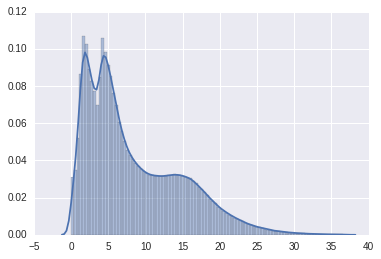

In [22]:
deltas = abs(np.vstack([np.zeros(35),(states[1][1:]-states[1][:-1])])).sum(axis=1)
distplot(deltas[deltas<37],bins=100)

Похоже на сумму трёх распределений, было бы интересно их разделить.

# Осознаём устройство чёрного ящика

Для действий 1, 2 и 0 построим таблицу со столбцами: расстояние между соседними состояниями, изменение числа очков и значение $f\_35$.

In [23]:
gain = np.zeros((n_actions,n_rows)) # будет хранить изменение числа очков для каждого хода для каждого прохождения
gain[1] = total_score[1] - np.append(0, total_score[1][:-1])
exploration_1 = np.hstack([deltas.reshape(-1,1),gain[1].reshape(-1,1),f_35[1].reshape(-1,1)])
exploration_1[:300]

array([[  0.00000000e+00,  -8.08000006e-03,   0.00000000e+00],
       [  4.01377716e+00,  -8.08079913e-03,   0.00000000e+00],
       [  4.59303361e+00,  -8.08080845e-03,   0.00000000e+00],
       [  4.78988517e+00,  -8.08080658e-03,   0.00000000e+00],
       [  4.33655396e+00,  -8.08081031e-03,   0.00000000e+00],
       [  3.46141080e-01,   3.25022377e-01,   0.00000000e+00],
       [  9.10990733e+00,   0.00000000e+00,   1.00000001e-01],
       [  8.10187769e+00,   3.24951172e-01,   1.00000001e-01],
       [  1.03214812e+01,   0.00000000e+00,   2.00000003e-01],
       [  9.91422883e+00,   0.00000000e+00,   2.00000003e-01],
       [  5.34223579e+00,   0.00000000e+00,   2.00000003e-01],
       [  5.58880590e+00,   0.00000000e+00,   2.00000003e-01],
       [  5.73435203e+00,   0.00000000e+00,   2.00000003e-01],
       [  9.67367544e+00,   0.00000000e+00,   2.00000003e-01],
       [  4.78024233e+00,   0.00000000e+00,   2.00000003e-01],
       [  4.52121730e+00,   0.00000000e+00,   2.0000000

In [24]:
exploration_1[1500:1520]

array([[  7.17307170e+00,  -7.81250000e-03,   1.10000002e+00],
       [  6.31364844e+00,  -7.81250000e-03,   1.10000002e+00],
       [  5.85999438e+00,  -4.17421722e+00,   1.10000002e+00],
       [  1.32836986e+01,  -8.59451294e-03,   1.10000002e+00],
       [  2.80953786e+00,  -7.81250000e-03,   1.10000002e+00],
       [  6.59982953e+00,  -7.81250000e-03,   1.10000002e+00],
       [  3.68896018e+00,  -7.81250000e-03,   1.10000002e+00],
       [  4.40299349e+00,  -7.81250000e-03,   1.10000002e+00],
       [  5.82976865e+00,  -7.81250000e-03,   1.10000002e+00],
       [  8.01209626e+00,  -7.81250000e-03,   1.10000002e+00],
       [  7.61448186e+00,  -7.81250000e-03,   1.10000002e+00],
       [  4.57709181e+00,   4.11718750e+00,   1.10000002e+00],
       [  1.49670275e+01,   4.11718750e+00,   1.10000002e+00],
       [  1.37686772e+01,  -7.81250000e-03,   1.10000002e+00],
       [  9.78795277e+00,  -7.81250000e-03,   1.10000002e+00],
       [  1.48908863e+00,  -7.81250000e-03,   1.1000000

In [25]:
gain[2] = total_score[2] - np.append(0, total_score[2][:-1])
exploration_2 = np.hstack([deltas.reshape(-1,1),gain[2].reshape(-1,1),f_35[2].reshape(-1,1)])
exploration_2[:300]

array([[  0.00000000e+00,  -8.08000006e-03,   0.00000000e+00],
       [  4.01377716e+00,  -8.08079913e-03,   0.00000000e+00],
       [  4.59303361e+00,  -8.08080845e-03,   0.00000000e+00],
       [  4.78988517e+00,  -8.08080658e-03,   0.00000000e+00],
       [  4.33655396e+00,  -8.08081031e-03,   0.00000000e+00],
       [  3.46141080e-01,  -8.08081031e-03,   0.00000000e+00],
       [  9.10990733e+00,  -8.08081031e-03,   0.00000000e+00],
       [  8.10187769e+00,  -8.08080286e-03,   0.00000000e+00],
       [  1.03214812e+01,  -8.08080286e-03,   0.00000000e+00],
       [  9.91422883e+00,  -8.08080286e-03,   0.00000000e+00],
       [  5.34223579e+00,  -8.08081031e-03,   0.00000000e+00],
       [  5.58880590e+00,  -8.08080286e-03,   0.00000000e+00],
       [  5.73435203e+00,  -8.08081776e-03,   0.00000000e+00],
       [  9.67367544e+00,  -8.08081031e-03,   0.00000000e+00],
       [  4.78024233e+00,  -8.08081776e-03,   0.00000000e+00],
       [  4.52121730e+00,  -8.08081776e-03,   0.0000000

In [26]:
exploration_2[1500:1520]

array([[  7.17307170e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  6.31364844e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  5.85999438e+00,   4.11718750e+00,  -1.10000002e+00],
       [  1.32836986e+01,  -7.81250000e-03,  -1.10000002e+00],
       [  2.80953786e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  6.59982953e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  3.68896018e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  4.40299349e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  5.82976865e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  8.01209626e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  7.61448186e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  4.57709181e+00,  -4.17421722e+00,  -1.10000002e+00],
       [  1.49670275e+01,  -4.17422485e+00,  -1.10000002e+00],
       [  1.37686772e+01,  -8.59069824e-03,  -1.10000002e+00],
       [  9.78795277e+00,  -7.81250000e-03,  -1.10000002e+00],
       [  1.48908863e+00,  -7.81250000e-03,  -1.1000000

Аналогично для действия 0:

In [27]:
gain[0] = total_score[0] - np.append(0, total_score[0][:-1])
exploration_0 = np.hstack([deltas.reshape(-1,1),gain[0].reshape(-1,1),f_35[0].reshape(-1,1)])
exploration_0[:300]

array([[  0.00000000e+00,  -8.08000006e-03,   0.00000000e+00],
       [  4.01377716e+00,  -8.08079913e-03,   0.00000000e+00],
       [  4.59303361e+00,  -8.08080845e-03,   0.00000000e+00],
       [  4.78988517e+00,  -8.08080658e-03,   0.00000000e+00],
       [  4.33655396e+00,  -8.08081031e-03,   0.00000000e+00],
       [  3.46141080e-01,   3.25022377e-01,   0.00000000e+00],
       [  9.10990733e+00,   0.00000000e+00,   1.00000001e-01],
       [  8.10187769e+00,   3.24951172e-01,   1.00000001e-01],
       [  1.03214812e+01,   0.00000000e+00,   2.00000003e-01],
       [  9.91422883e+00,   0.00000000e+00,   2.00000003e-01],
       [  5.34223579e+00,   0.00000000e+00,   2.00000003e-01],
       [  5.58880590e+00,   0.00000000e+00,   2.00000003e-01],
       [  5.73435203e+00,   0.00000000e+00,   2.00000003e-01],
       [  9.67367544e+00,   0.00000000e+00,   2.00000003e-01],
       [  4.78024233e+00,   0.00000000e+00,   2.00000003e-01],
       [  4.52121730e+00,   0.00000000e+00,   2.0000000

In [28]:
exploration_0[1500:1520]

array([[  7.1730717 ,   0.        ,   1.        ],
       [  6.31364844,   0.        ,   1.        ],
       [  5.85999438,  -3.78750038,   1.        ],
       [ 13.28369858,   0.        ,   1.        ],
       [  2.80953786,   0.        ,   1.        ],
       [  6.59982953,   0.        ,   1.        ],
       [  3.68896018,   0.        ,   1.        ],
       [  4.40299349,   0.        ,   1.        ],
       [  5.82976865,   0.        ,   1.        ],
       [  8.01209626,   0.        ,   1.        ],
       [  7.61448186,   0.        ,   1.        ],
       [  4.57709181,   3.69999981,   1.        ],
       [ 14.96702747,   3.375     ,   0.89999998],
       [ 13.7686772 ,   0.        ,   0.89999998],
       [  9.78795277,   0.        ,   0.89999998],
       [  1.48908863,   0.        ,   0.89999998],
       [  7.65543449,   0.        ,   0.89999998],
       [  1.96919734,   0.        ,   0.89999998],
       [ 16.89564098,   0.        ,   0.89999998],
       [  3.62072119,   0.     

Нижеизложенные суждения, наверное, сложно понять с первого раза, поэтому после прочтения можно посмотреть дальнейшие выкладки и код. Возможно, после этого станет понятнее.

Внимательно посмотрев в таблицы, можно заметить следующие закономерности:
1. При изменении $f\_35$ мы получаем бонус 0,325.
2. Состояния, в которых мы можем повысить $f\_35$ действием 1, и состояния, в которых мы можем понизить $f\_35$ действием 2, не пересекаются. Действие 0 изменяет $f\_35$ в любом из объединения этих состояний и только в них в соответствующую сторону.
3. В некоторых состояниях мы получаем прибыль, пропорциональную $f\_35$. Она может быть как положительной, так и отрицательной. Обычно это характеризуется большим расстоянием до следующего состояния среды. 
4. Введём амплитуду - отношение прибыли, обусловленной значением $f\_35$ к значению $f\_35$. Амплитуды дискретны и кратны 0,375. Они бывают обоих знаков.
5. Отрицательная прибыль, обусловленная значением $f\_35$, по модулю на 1% больше положительной.
6. Если мы меняем значение $f\_35$ и одновременно получаем прибыль за счёт значения $f\_35$, то изменение $f\_35$ и значение амплитуды в данном состоянии имеют разный знак. При этом при подсчёте прибыли учитывается уже новое значение $f\_35$.
7. Если мы долгое время не меняем значение $f\_35$, то спустя некоторое время (несколько сотен ходов) накладывается штраф -0,0078125 в ход. 

Для простоты объяснения представим биржевую интерпретацию, идея которой напрашивалась из полученных графиков $total\_score$ и была предложена в обсуждении.  
В каждый момент времени агенту предлагается позиция, на которую он может отреагировать покупкой(действие 1), продажей(действие 2), бездействием(действие 3) и заявкой на куплю/продажу одновременно(действие 0). Если сделка совершается, мы получаем бонус 0,325 и меняем значение $f\_35$, которое имеет смысл количества акций. Далее мы по сути получаем прибыль от количества наших акций, но здесь лучше не рисковать: если знак амплитуды позиции не совпадает со знаком $f\_35$, то мы теряем на 1% больше.
Если нам вдруг удалось купить/продать акцию, и мы получаем прибыль за значение $f\_35$, то в этот ход мы бы получили больше прибыли, если бы этого не делали, однако это может окупиться в дальнейшем.

Дальнейшая наша цель - построить алгоритм, который будет предсказывать будущие амплитуды и изменения $f\_35$. Для этого нужно вычленить ненулевые амплитуды всех представленных в _train_'e позиций.

In [29]:
n_penalty = 200 # примерное количество ходов, после которого мы получаем штраф за однообразные действия
for num in range(new_epoches.shape[0]):
    if num!= new_epoches.shape[0]-1: gain[1][new_epoches[num]+n_penalty:new_epoches[num+1]]+=0.0078125
    else: gain[1][new_epoches[num]+n_penalty:]+=0.0078125

gain_margin = np.append(0,gain[1][:-1]) # смещаем gain на 1 вниз, чтобы потом было удобнее делить на f_35
f_35_delta = f_35[1][:] - np.append(0,f_35[1][:-1]) # смотрим на изменения f_35
f_35_delta[abs(f_35_delta)>0.15] = 0 # f_35 больше, чем на 0.1 только при начале "новой эпохи"
mask_f_35_delta = abs(f_35_delta) > 0
gain_margin[mask_f_35_delta]-=0.325 # вычитаем бонусные 0.325, когда меняется f_35
gain_margin[gain_margin<0]/=1.01 # делаем поправку на штрафной 1%, когда знак амплитуды и f_35 не совпадает
gain_margin[abs(gain_margin)<0.1] = 0 # заменяем малые приросты на 0, так как в данных есть непонятный шум

In [30]:
gain_margin[:150]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -1.12178992,
       -1.1250774 ,  0.        ,  1.125     ,  1.125     ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -2.25015466, -2.25015466,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [31]:
gain_margin[1500:1520]

array([ 0.        ,  0.        ,  0.        , -4.12515319,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  4.125     ,  4.125     ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

Теперь можно проследить, как изменился график распределения расстояний между позициями, когда мы отобрали только те, которые имеют ненулевую амплитуду. Это хороший знак, значит вышеописанные действия имели смысл.

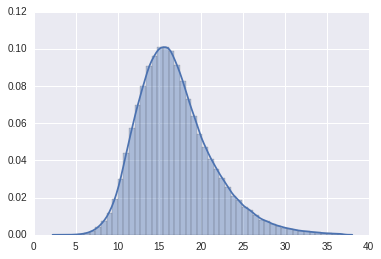

In [32]:
mask_offer_1 = abs(gain_margin)>0
deltas_offer = deltas[mask_offer_1]
distplot(deltas_offer[deltas_offer<37])

Из суммы каких двух других распределений состоит другой график - неизвестно. Возможно, это распределения для состояний, когда $f\_35$ меняется, и когда $f\_35$ не меняется.
Из оставшегося распределения можно вытащить ещё одно, для состояний, в которых может поменяться $f\_35$.

(0, 20)

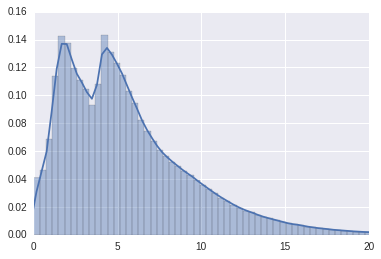

In [33]:
not_deltas_offer = deltas[~mask_offer_1]
distplot(not_deltas_offer[not_deltas_offer<37],bins=100)
plt.xlim(0,20)

(0, 20)

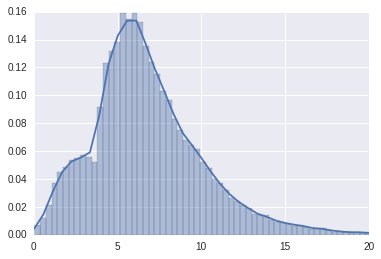

In [37]:
f_35_delta = np.append(0,f_35[0][1:]-f_35[0][:-1]) 
mask_delta = abs(f_35_delta) > 0
distplot(deltas[mask_delta & ~mask_offer_1],bins=200)
plt.xlim(0,20)

Для действия 2 можно провести аналогичные операции и увидеть, что там выполняются те же самые правила.

In [38]:
for num in range(new_epoches.shape[0]):
    if num!= new_epoches.shape[0]-1: gain[2][new_epoches[num]+n_penalty:new_epoches[num+1]]+=0.0078125
    else: gain[2][new_epoches[num]+n_penalty:]+=0.0078125

gain_margin = np.append(0,gain[2][:-1]) # смещаем gain на 1 вниз
f_35_delta = f_35[2][:] - np.append(0,f_35[2][:-1]) # смотрим на изменения f_35
f_35_delta[abs(f_35_delta)>0.15] = 0 # f_35 больше, чем на 0.1 только при начале "новой эпохи"
mask_f_35_delta = abs(f_35_delta) > 0
gain_margin[mask_f_35_delta]-=0.325
gain_margin[gain_margin<0]/=1.01
gain_margin[abs(gain_margin)<0.1] = 0 # заменяем малые приросты на 0, они могут быть связаны с наличием шума

In [39]:
gain_margin[:150]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.37175483, -0.37500965,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.37499997,  0.37500001,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [40]:
gain_margin[1500:1515]

array([ 0.        ,  0.        ,  0.        ,  4.125     ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -4.12515319, -4.12516075,  0.        ])

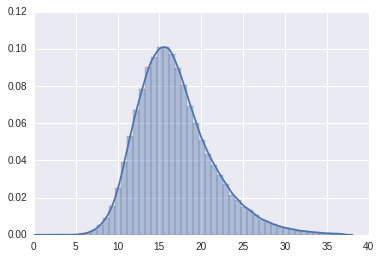

In [41]:
mask_offer_2 = abs(gain_margin)>0
deltas_offer = deltas[mask_offer_2]
distplot(deltas_offer[deltas_offer<37])

Мы имеем две маски: $mask\_offer\_1$ и $mask\_offer\_2$, которые показывают, какие позиции обладают ненулевой амплитудой, полученные исходя из действий 1 и 2 соответственно. Если мы сделаем побитовое И, то количество элементов практически не изменится - хороший знак. При этом ненулевой амплитудой обладает ~1/4 всех состояний.

In [42]:
mask_offer = mask_offer_1 & mask_offer_2
print(mask_offer_1.sum(),mask_offer_2.sum(),mask_offer.sum()) # как видно, маски почти полностью совпадают

305287 305272 305216


In [43]:
indexes = np.arange(n_rows)[mask_offer] # индексы, когда позиция меняется
indexes[:20]

array([ 32,  33,  62,  63,  86,  87,  89, 100, 109, 110, 136, 137, 143,
       144, 145, 149, 154, 156, 160, 161])

In [44]:
offer_states_train = np.zeros((mask_offer.sum(),n_features-1)) # создадим массив, в котором будем хранить усреднённые значения позиций с ненулевой амплитудой
for i in range(1,indexes.shape[0]): offer_states_train[i] = states[0][indexes[i-1]:indexes[i]].mean(axis=0) # усредняем значение позиции по всем разам
offer_gain = gain_margin[mask_offer]
offer_f_35 = f_35[2][mask_offer]

Получим амплитуды как отношение прибыли к значению $f\_35$.

In [45]:
ampl_train = offer_gain/offer_f_35
ampl_train[(ampl_train==np.inf)|(ampl_train==-np.inf)] = 0 # заменяем бесконечность на 0

In [46]:
# (ampl!=ampl).sum()

In [47]:
# ampl[(ampl!=ampl)]=0 # избавляемся от NaN, вызванными изменением "эпохи"

Ещё раз убеждаемся, что амплитуды дискретны.

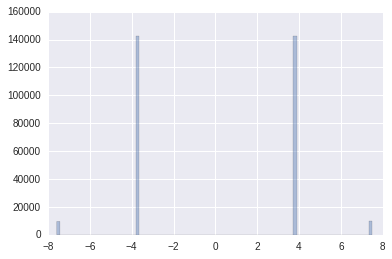

In [48]:
distplot(ampl_train[abs(ampl_train)<10],bins=100,kde=False)

Так как из-за шума и погрешности float мы получаем значения амплитуд с погрешностью, то стоит округлить близкие значения.

In [49]:
b=3.75; b1=3.63; b2=3.88
for i in range(1,7):
    mask_ampl = (abs(ampl_train)>i*b1)&(abs(ampl_train)<i*b2)
    # print(i,mask_ampl.sum())
    ampl_train[mask_ampl] = i * b * np.sign(ampl_train[mask_ampl])
pd.value_counts(ampl_train).iloc[:12]

-3.75     142380
 3.75     142188
-7.50       9580
 7.50       9536
 11.25       501
-11.25       498
-15.00       190
 15.00       173
-18.75        47
 18.75        36
 22.50        18
-22.50        16
dtype: int64

По-другому представленные амплитуды. Видно, что их знаки почти всегда чередуются, что усложняет получение прибыли за счёт большого значения $f\_35$.

In [50]:
ampl_train[:200]/3.75

array([ 1.,  1., -1., -1., -1., -1., -2., -2.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1.,  1., -2.,  2., -1.,  1.,  1., -1.,  1.,  1.,
       -2.,  2.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  2., -1., -1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1.,  2., -1., -1.,  2., -1.,
        1.,  1.,  1., -1., -1.,  1.,  1., -1.,  2.,  2.,  3., -1.,  1.,
       -1.,  1.,  1., -1., -1.,  1., -1.,  1., -2.,  2., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1.,  1., -2., -1.,  1.,  1.,  1.,  1.,
        1., -2.,  1.,  1., -2., -2.,  1., -1.,  1., -1.,  1.,  1.,  2.,
        1.,  1., -1.,  1., -2.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
        1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,
       -1.,  1., -1., -2.,  1., -1., -1., -1.,  1.,  1., -2.,  1.,  1.,
       -1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1., -2.,  1., -1.,  1., -1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1

Теперь мы хотим получить амплитуды для $test\_level$.

In [51]:
bbox.load_level("levels/test_level.data", verbose=1)
n_rows = bbox.get_max_time()
f_35, total_score, history = np.zeros((n_actions,n_rows)), np.zeros((n_actions,n_rows)), np.zeros((n_actions,n_rows))
states, gain = np.zeros((n_actions,n_rows,n_features-1)), np.zeros((n_actions,n_rows))
n_step = 0; has_next = True

for act in range(n_actions):
    while has_next:
        state = bbox.get_state()
        states[act,n_step,:] = state[:35].copy()
        has_next = bbox.do_action(act)
        history[act,n_step] = act
        total_score[act,n_step] = bbox.get_score()
        f_35[act,n_step] = state[35].copy()
        n_step+=1
    score = bbox.finish(verbose=0)
    print('act = '+str(act)+'  score = %.0d'%score)
    bbox.reset_level(); has_next = True; n_step = 0

Level has been loaded: max_time = 1258935, n_features = 36, n_actions = 4
act = 0  score = -14011
act = 1  score = -16162
act = 2  score = -17785
act = 3  score = -10191


Ещё раз убеждаемся, что состояние переменных 0-34 не зависит от наших действий.

In [52]:
print(abs(states[0]-states[1]).max(),abs(states[0]-states[2]).max(),abs(states[0]-states[3]).max())

0.0 0.0 0.0


Обрабатываем полученные данные:

In [53]:
new_epoches = np.array([0,146631,259142,401800,557441,750809,873755,979972,1035048,1136112])
deltas = abs(np.vstack([np.zeros(35),(states[1][1:]-states[1][:-1])])).sum(axis=1)
gain[1] = total_score[1] - np.append(0, total_score[1][:-1])
for num in range(new_epoches.shape[0]):
    if num!= new_epoches.shape[0]-1: gain[1][new_epoches[num]+n_penalty:new_epoches[num+1]]+=0.0078125
    else: gain[1][new_epoches[num]+n_penalty:]+=0.0078125

gain_margin = np.append(0,gain[1][:-1]) # смещаем gain на 1 вниз
f_35_delta = f_35[1][:] - np.append(0,f_35[1][:-1]) # смотрим на изменения f_35
f_35_delta[abs(f_35_delta)>0.15] = 0 # f_35 больше, чем на 0.1 только при начале "новой эпохи"
mask_f_35_delta = abs(f_35_delta) > 0
gain_margin[mask_f_35_delta]-=0.325
gain_margin[gain_margin<0]/=1.01
gain_margin[abs(gain_margin)<0.1] = 0 # заменяем малые приросты на 0

In [54]:
gain_margin[:50]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.74678634,  0.74999997,
        0.        ,  0.37500003, -0.37500969,  0.        ,  0.375     ,
       -0.37500967,  0.        ,  0.        ,  0.37499997, -0.37500965,
        0.375     ,  0.        ,  0.        , -0.37500967,  0.        ,
        0.        ,  0.        ,  0.74999997,  0.        , -0.75001932,
        0.        ,  0.75000006, -0.75001938,  0.74999997, -0.75001932])

Снова получаем похожее распределение:

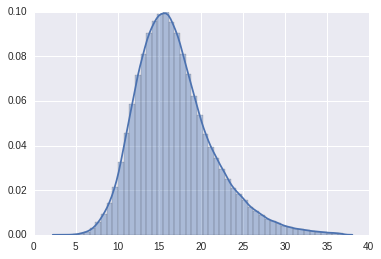

In [55]:
mask_offer_1 = abs(gain_margin)>0
deltas_offer = deltas[mask_offer_1]
distplot(deltas_offer[deltas_offer<37])

Для действия 2:

In [56]:
gain[2] = total_score[2] - np.append(0, total_score[2][:-1])
for num in range(new_epoches.shape[0]):
    if num!= new_epoches.shape[0]-1: gain[2][new_epoches[num]+n_penalty:new_epoches[num+1]]+=0.0078125
    else: gain[2][new_epoches[num]+n_penalty:]+=0.0078125

gain_margin = np.append(0,gain[2][:-1]) # смещаем gain на 1 вниз
f_35_delta = f_35[2][:] - np.append(0,f_35[2][:-1]) # смотрим на изменения f_35
f_35_delta[abs(f_35_delta)>0.15] = 0 # f_35 больше, чем на 0.1 только при начале "новой эпохи"
mask_f_35_delta = abs(f_35_delta) > 0
gain_margin[mask_f_35_delta]-=0.325
gain_margin[gain_margin<0]/=1.01
gain_margin[abs(gain_margin)<0.1] = 0 # заменяем малые приросты на 0

In [57]:
gain_margin[:50]

array([ 0.        ,  0.        , -0.37174745,  0.37499999, -0.37500966,
        0.37500001, -0.37500968,  0.37500001, -0.37500967,  0.375     ,
       -0.37500967,  0.37499999,  0.        , -0.37500966,  0.        ,
        0.        ,  0.375     , -0.37500967,  0.        ,  0.        ,
        0.37500001,  0.        ,  0.        ,  0.74999997, -1.49679955,
        0.        , -1.12169321,  1.12499999,  0.        , -1.87171256,
        1.875     ,  0.        ,  0.        , -2.24667393,  2.25      ,
       -2.62182852,  0.        ,  0.        ,  2.625     ,  0.        ,
        0.        ,  0.        , -2.6249227 ,  0.        ,  2.625     ,
        0.        , -2.99659656,  3.        , -3.37213804,  3.375     ])

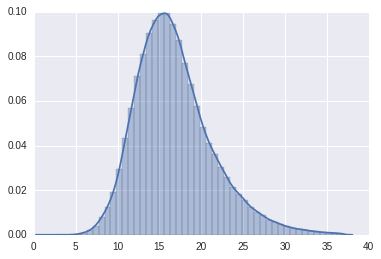

In [58]:
mask_offer_2 = abs(gain_margin)>0
deltas_offer = deltas[mask_offer_2]
distplot(deltas_offer[deltas_offer<37])

In [59]:
mask_offer = mask_offer_1 & mask_offer_2
print(mask_offer_1.sum(),mask_offer_2.sum(),mask_offer.sum()) # как видно, маски почти полностью совпадают

316033 316053 315997


In [60]:
indexes = np.arange(n_rows)[mask_offer] # индексы, когда заявка меняется
indexes[:20]

array([23, 24, 26, 27, 29, 30, 33, 34, 35, 38, 42, 44, 46, 47, 48, 49, 50,
       51, 53, 54])

Получаем соответствующие значения позиций и амплитуд:

In [61]:
offer_states_test = np.zeros((mask_offer.sum(),n_features-1)) # создадим массив, в котором будем хранить усреднённые значения позиций с ненулевой амплитудой
for i in range(1,indexes.shape[0]): offer_states_test[i] = states[0][indexes[i-1]:indexes[i]].mean(axis=0) # усредняем значение позиции по всем разам
offer_gain = gain_margin[mask_offer]
offer_f_35 = f_35[2][mask_offer]
ampl_test = offer_gain/offer_f_35
ampl_test[(ampl_test==np.inf)|(ampl_test==-np.inf)]=0 # заменяем бескнечность на 0

Ещё раз убеждаемся в дискретности амплитуд:

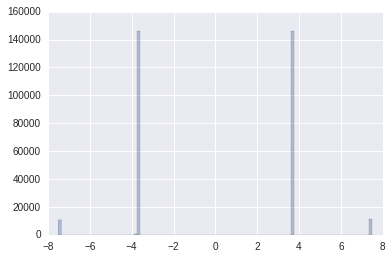

In [62]:
distplot(ampl_test[abs(ampl_test)<9],bins=100,kde=False)

In [63]:
b=3.75; b1=3.63; b2=3.88
for i in range(1,7):
    mask_ampl = (abs(ampl_test)>i*b1)&(abs(ampl_test)<i*b2)
    # print(i,mask_ampl.sum())
    ampl_test[mask_ampl] = i * b * np.sign(ampl_test[mask_ampl])
pd.value_counts(ampl_test).iloc[:12]

-3.75     146539
 3.75     145968
 7.50      10974
-7.50      10669
-11.25       642
 11.25       641
 15.00       203
-15.00       175
 18.75        42
-18.75        40
-22.50        27
 22.50        26
dtype: int64

Снова видно, что знаки амплитуд часто чередуются один за другим.

In [64]:
ampl_test[:200]/3.75

array([-2.,  2.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,
        1., -1., -1.,  1., -1., -2.,  2., -1.,  1., -2.,  2.,  2., -1.,
        1., -1.,  1.,  1.,  1., -1., -1.,  2., -1., -1.,  2., -1., -1.,
       -2.,  1.,  1.,  1., -1.,  2.,  1.,  1., -1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  2., -1., -1.,  1., -1.,  1.,
       -1., -2., -1.,  1., -1.,  1., -1.,  1., -2.,  2., -2.,  1.,  1.,
       -1., -1.,  1.,  1., -1.,  1., -2.,  1.,  1., -1., -1.,  1., -1.,
        1.,  1., -1.,  1., -2.,  1., -1.,  2., -1., -1.,  2., -2.,  1.,
        1., -2.,  1.,  1.,  1., -1.,  1., -1.,  2., -1., -1.,  1.,  1.,
       -1., -1., -2.,  1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1.,
       -1., -1., -1.,  1., -1., -1.,  2., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  1., -2.,  2., -1.,  1

Теперь можно понять, какие признаки влияют на амплитуду, т.е. на масштаб изменения очков в состоянии.

<Container object of 3 artists>

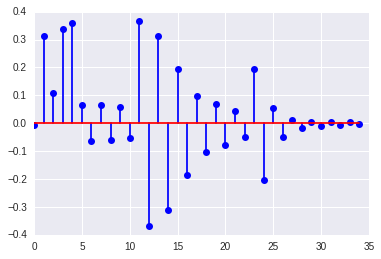

In [65]:
ampl_corr = np.corrcoef(ampl_train,offer_states_train[:,:].T)[0][1:]
plt.stem(ampl_corr)

<Container object of 3 artists>

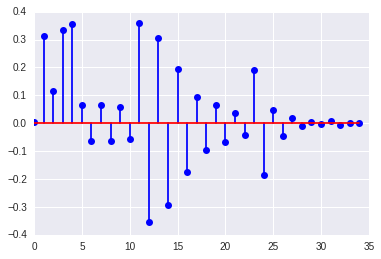

In [66]:
ampl_corr = np.corrcoef(ampl_test,offer_states_test[:,:].T)[0][1:]
plt.stem(ampl_corr)

Есть некоторая корреляция, следовательно, значение амплитуды можно предсказать.

# Построение модели
Идея построения агента заключается в предсказании будущих амплитуд и соответствующей корректировке значения $f\_35$. Для обучения в качестве train будет выступать массив с позициями, а в качестве целевой переменной - среднее экспоненциальное взвешенное следующих n амплитуд. Были опробованы и другие веса слагаемых, такие, как равномерные, линейно убывающие~~, веса "в виде треугольника" и в виде "экспоненциально затухающего треугольника"~~ и прочие, но результаты оказались хуже.

Моделью выступит Ridge-регрессия. Был опробован xgboost, однако он показал результаты хуже, видимо, из-за переобучения, и сложности модели даже при глубине деревьев 1. Регрессия будет предсказывать кумулятивную сумму следующих амплитуд для действий 1 и 2 с учётом штрафа в 1% за расхождение амплитуды и $f\_35$ в знаке. Предсказание для действия 0 будет тогда средним арифметическим предсказаний для 1 и 2.

Кроме того, для избегания больших значений $f\_35$, когда агент чаще уходит в минус, чем в плюс, введём штрафы за большие значения $f\_35$. Для общности эти штрафы будут разными для действий 1 и 2. Дополнительно будут начисляться бонусы за изменения $f\_35$, а т.к. вероятность изменения количества акций для действия 0 в два раза выше, то для него бонус будет в 2 раза больше, чем для действий 1 и 2. Учитывая, что вероятности повышения и понижения $f\_35$ одинаковы и $f\_35$ не достигает граничных значений, для простоты модели будем добавлять к полезности действий 1 и 2 константу $k$, соответственно для действия 0 эта добавка составит $2*k$.

Таким образом будет вычислена некоторая полезность для каждого действия, причём для действия 3 она будет равна 0. Агент будет выбирать действие с максимальной полезностью.

In [67]:
def weighted_ampl_exp(ampl,n_0,act):
    decay = 2.718 ** (-3.2/n_0) # выбираем затухание так, чтобы в начале был вес 1, а в конце 0,04
    result = np.zeros(ampl.shape[0])
    addition = ampl.copy()
    # Сделаем поправку на комиссии на амплитуды при неправильном знаке f
    if act==1: addition[addition<0]*=1.01
    else: addition[addition>0]*=1.01
    for i in range(n_0):
        if i!=0: result[:-i] += addition[i:] * decay**i
        else: continue
    return result

Обучаемся с разными параметрами на тренировочном уровне, проходим тестовый и наоборот, считаем среднее:

In [68]:
n = 36; k = 0; f_35_penalty = 0.29; r = 1; f_35_penalty_on = True
score = np.zeros(2); act_portions = np.zeros((2,4))

def test_params(k,n,f_35_penalty):
    for n_level in range(2):
        if n_level==0:
            ampl = ampl_test.copy(); offer_states = offer_states_test.copy()
            bbox.load_level("levels/train_level.data", verbose=0)
        else:
            ampl = ampl_train.copy(); offer_states = offer_states_train.copy()
            bbox.load_level("levels/test_level.data", verbose=0)

        f_35_penalty_1 = f_35_penalty; f_35_penalty_2 = f_35_penalty * r
        n_rows = bbox.get_max_time()
        gain, total_score, history_lin, f_35 = np.zeros(n_rows), np.zeros(n_rows), np.zeros(n_rows), np.zeros(n_rows)
        ampl_cum_sum = np.zeros((ampl.shape[0],2))
        ampl_cum_sum[:,0] = weighted_ampl_exp(ampl,n,1) * 1
        ampl_cum_sum[:,1] = weighted_ampl_exp(ampl,n,2) * (-1)
        lr = Ridge()
        a = abs(ampl_cum_sum).mean() # отнормируем на среднее абсолютное значение
        lr.fit(offer_states,ampl_cum_sum/a)
        lr_coefs = lr.coef_
        lr_free_coefs = lr.intercept_
        has_next, n_step, last_score = True, 0, 0
        # act = -1; long = 0; state_len=0
        predict = np.zeros(2); cum_sum= np.zeros(4)
        while has_next:
            # last_act = act
            # if n_step==0: last_state = np.zeros(n_features)
            # else: last_state = state
            state = bbox.get_state()
            predict[:2] = np.dot(lr_coefs,state[:-1]) + lr_free_coefs

            if state[35] > 0: # если f_35!=0, то предсказания для действий 1 и 2 противоположны (без учёта k)
                cum_sum[1] = predict[0] + k
                cum_sum[2] = -predict[0] + k
            elif state[35] < 0:
                cum_sum[1] = -predict[1] + k
                cum_sum[2] = predict[1] + k
            elif state[35] == 0: # если f_35==0, то предсказания для действий 1 и 2 будут разные 
                cum_sum[1] = predict[0] + k
                cum_sum[2] = predict[1] + k

            cum_sum[0] = (cum_sum[1]+cum_sum[2])/2 + k

            if f_35_penalty_on:
                cum_sum[1]-=f_35_penalty_1*state[35]#*a
                cum_sum[2]+=f_35_penalty_2*state[35]#*a

            act = cum_sum.argmax()

    #         if combo_penalty:
    #             if long > long_crit:
    #                 cum_sum[last_act]-=0.0078125#/4.5
    #                 # print('Hey '+str(n_step))
            has_next = bbox.do_action(act); history_lin[n_step] = act
            n_step+=1
    #         if combo_penalty:
    #             if last_act==act: long+=1
    #             else: long = 0
            # if n_step%50000==0: print(str(n_step) + '    %.0f'%cur_score + '    %.1f'%(time.time()-t1))

        score[n_level] = bbox.finish(verbose=0)
        for act in range(n_actions): act_portions[n_level,act] = np.round((history_lin==act).sum()/history_lin.shape[0],3)

        if n_level==1: print('Score = %.0f'%score.mean()+', Train = %.0f'%(score[0])+', Test = %.0f'%(score[1])+
                             ', act portions '+str(act_portions[:,0].mean())+' '+str(act_portions[:,1].mean())+' '
                             +str(act_portions[:,2].mean())+' '+str(act_portions[:,3].mean()))

n = 34; f_35_penalty = 0.15; k = 0
# Таким grid search'ем можно подобрать параметры
# for k in np.arange(-0.003,0.004,0.002):
#     for f_35_penalty in np.arange(0.14,0.18,0.01):
#         for n in np.arange(31,35,1):
#     print (k,n,f_35_penalty)
#     test_params(k,n,f_35_penalty)


Оказывается, что штраф, накладываемый на значения $f\_35$, существенно влияет на результат. Можно сказать, что train и test уровни отличаются по "рисковости", и для получения хорошего результата на финальном уровне следует послать несколько решений с разными параметрами, одно из которых должно "выстрелить".

In [69]:
n = 34; f_35_penalty = 0.15; k = 0
# for k in [0]:
for f_35_penalty in np.arange(0.05,0.40,0.02):
    print (k,n,f_35_penalty)
    test_params(k,n,f_35_penalty)

0 34 0.05
Score = 211, Train = -223, Test = 644, act portions 0.0 0.47 0.481 0.049
0 34 0.07
Score = 333, Train = 50, Test = 615, act portions 0.0 0.4685 0.4775 0.0545
0 34 0.09
Score = 449, Train = 306, Test = 592, act portions 0.0 0.4665 0.474 0.0595
0 34 0.11
Score = 382, Train = 206, Test = 557, act portions 0.0 0.465 0.471 0.064
0 34 0.13
Score = 364, Train = 193, Test = 534, act portions 0.0 0.463 0.468 0.069
0 34 0.15
Score = 430, Train = 364, Test = 495, act portions 0.0 0.461 0.466 0.073
0 34 0.17
Score = 300, Train = 266, Test = 334, act portions 0.0 0.459 0.464 0.077
0 34 0.19
Score = 326, Train = 327, Test = 325, act portions 0.0 0.458 0.4615 0.08
0 34 0.21
Score = 297, Train = 311, Test = 283, act portions 0.0 0.457 0.46 0.083
0 34 0.23
Score = 358, Train = 410, Test = 305, act portions 0.0 0.456 0.458 0.086
0 34 0.25
Score = 368, Train = 433, Test = 303, act portions 0.0 0.4545 0.456 0.0895
0 34 0.27
Score = 340, Train = 399, Test = 280, act portions 0.0 0.453 0.4545 0.09

Для улучшения качества модели регрессия была обучена на обоих уровнях, результат был отправлен на проверку и получил 269 очков, что подтверждает отсутствие переобучения.

In [ ]:
n = 36
offer_states = np.vstack([offer_states_train,offer_states_test])
ampl = np.append(ampl_train,ampl_test)
ampl_cum_sum = np.zeros((ampl.shape[0],2))
ampl_cum_sum[:,0] = weighted_ampl_exp(ampl,n,1) * 1
ampl_cum_sum[:,1] = weighted_ampl_exp(ampl,n,2) * (-1)

lr = Ridge()
lr.fit(offer_states,ampl_cum_sum)
lr.coef_

In [ ]:
lr.intercept_

Можно заметить, что коэффициенты при многих парах фичей имеют разные знаки. Если обучить регрессию на их разностях,  мы получим такой же результат.

Мы можем улучшить результаты базовой регрессии, если добавив её предсказания с некоторыми весами:

In [ ]:
coefs = np.loadtxt("reg_coefs.txt").reshape(4,37)
lr_coefs_0 = coefs[:,:-1][:,:]
lr_free_coefs_0 = coefs[:,-1][:]

k = 0; n = 36; f_35_penalty = 0.27

def test_params_with_base_agent(w0):
    # w0 - вес, с которым учитываются предсказания построенной регрессии
    for n_level in range(2):
        if n_level==0:
            ampl = ampl_test.copy(); offer_states = offer_states_test.copy()
            bbox.load_level("levels/train_level.data", verbose=0)
        else:
            ampl = ampl_train.copy(); offer_states = offer_states_train.copy()
            bbox.load_level("levels/test_level.data", verbose=0)

        f_35_penalty_1 = f_35_penalty; f_35_penalty_2 = f_35_penalty * r
        n_rows = bbox.get_max_time()
        gain, total_score, history_lin, f_35 = np.zeros(n_rows), np.zeros(n_rows), np.zeros(n_rows), np.zeros(n_rows)
        ampl_cum_sum = np.zeros((ampl.shape[0],2))
        ampl_cum_sum[:,0] = weighted_ampl_exp(ampl,n,1) * 1
        ampl_cum_sum[:,1] = weighted_ampl_exp(ampl,n,2) * (-1)
        lr = Ridge()
        a = abs(ampl_cum_sum).mean() # отнормируем на среднее абсолютное значение
        lr.fit(offer_states,ampl_cum_sum/a)
        lr_coefs = lr.coef_
        lr_free_coefs = lr.intercept_
        has_next, n_step, last_score = True, 0, 0
        # act = -1; long = 0; state_len=0
        predict = np.zeros(2); cum_sum= np.zeros(4)
        while has_next:
            # last_act = act
            # if n_step==0: last_state = np.zeros(n_features)
            # else: last_state = state
            state = bbox.get_state()
            predict[:2] = np.dot(lr_coefs,state[:-1]) + lr_free_coefs

            if state[35] > 0: # если f_35!=0, то предсказания для действий 1 и 2 противоположны (без учёта k)
                cum_sum[1] = predict[0] + k
                cum_sum[2] = -predict[0] + k
            elif state[35] < 0:
                cum_sum[1] = -predict[1] + k
                cum_sum[2] = predict[1] + k
            elif state[35] == 0: # если f_35==0, то предсказания для действий 1 и 2 будут разные
                cum_sum[1] = predict[0] + k
                cum_sum[2] = predict[1] + k

            cum_sum[0] = (cum_sum[1]+cum_sum[2])/2 + k
            
            if f_35_penalty_on:
                cum_sum[1]-=f_35_penalty_1*state[35]#*a
                cum_sum[2]+=f_35_penalty_2*state[35]#*a

    #         if combo_penalty:
    #             if long > long_crit:
    #                 cum_sum[last_act]-=0.0078125#/4.5
    #                 # print('Hey '+str(n_step))
            
            act = (w0*(np.dot(lr_coefs_0,state) + lr_free_coefs_0) + (1-w0)*cum_sum).argmax()
            has_next = bbox.do_action(act); history_lin[n_step] = act
            n_step+=1
    #         if combo_penalty:
    #             if last_act==act: long+=1
    #             else: long = 0
            # if n_step%50000==0: print(str(n_step) + '    %.0f'%cur_score + '    %.1f'%(time.time()-t1))

        score[n_level] = bbox.finish(verbose=0)
        for act in range(n_actions): act_portions[n_level,act] = np.round((history_lin==act).sum()/history_lin.shape[0],3)

        if n_level==1: print('Score = %.0f'%score.mean()+', Train = %.0f'%(score[0])+', Test = %.0f'%(score[1])+
                             ', act portions '+str(act_portions[:,0].mean())+' '+str(act_portions[:,1].mean())+' '
                             +str(act_portions[:,2].mean())+' '+str(act_portions[:,3].mean()))

for w0 in np.arange(0.01,0.3,0.05):
            print (w0)
            test_params_with_base_agent(w0)

# Выводы:
Судя по успешным результатам регрессии, чёрный ящик действительно работает по вышеописанным правилам. Основную сложность представляет предсказание будущих амплитуд и изменений $f\_35$ - именно за счёт этих двух факторов агент зарабатывает очки.

# Что было опробовано, но не дало результата:
1. Q-learning с различными алгоритмами, такими, как линейная регрессия, xgboost, neural nets, как с нуля, так и на основе решений базового агента. Оказалось проще "руками" понять суть чёрного ящика.
2. Учёт длительности позиции при предсказании будущих амплитуд не дал видимого результата.
3. Предсказание каждой из N будущих амплитуд в отдельности. В таком подходе точность оказалась ниже, а алгоритм работал дольше.
4. Различные функции весов. Оптимальной оказалось именно взвешенное экспоненциальное среднее, причём начиная со следующей, а не с текущей амплитуды, так как иначе алгоритм собирает меньше бонусов за смену $f\_35$.
5. Random Forest и KNN из sklearn работают очень долго для BlackBox.

# Что было опробовано, но не хватило ~~ума~~ времени для отладки:
1. Предсказание знака ближайшей амплитуды. Это позволяет повысить/понизить важности соответствующих действий и чаще собирать бонусы за смену $f\_35$. С помощью простой регрессии можно получить точность 70-80%, что может существенно улучшить результат.
2. Предсказание длительности следующей позиции. С помощью xgboost можно достичь очень хорошей точности, mae порядка 0,5-1. Это может быть полезно, так как чем дольше длится позиция, тем сильнее можно изменить $f\_35$, можно будет внести соответствующие поправки.
3. Ввести штраф не просто за значение $f\_35$, а за некоторую функцию $g(f\_35)$, например, пропорциональную кубу этой переменной.

# Что можно улучшить в решении
1. Предсказывать изменение $f\_35$, когда позиция не сменяется. Это позволит более гибко изменять $f\_35$ и получать дополнительные очки.
2. Использовать нейронные сети вместо линейной регрессии, либо очень аккуратно настроить xgboost.



# Дополнительные гипотезы
1. Базовая линейная регрессия обучена на готовых амплитудах, и возможно, изменениях $f\_35$ на всех уровнях. Этим объясняется её стабильность и хороший результат ~2000 на каждом уровне. Если обучить описаные в решении регрессии "на будущем", тоже получается результат ~2000.

